**Integrantes**
- Erika Espinosa
- Monica Quiroga
- Karla Rodriguez

# Acceder a un entorno de trabajo con GPU

In [ ]:
!nvidia-smi

Sat Sep 30 22:53:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Instalación de librerias

In [ ]:
!pip install transformers
!pip install emoji
!pip install torch
#!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz
#!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt
#!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/config.json
!tar -xzvf pytorch_weights.tar.gz
!mv config.json pytorch/.
!mv vocab.txt pytorch/.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 8.2 MB/s eta 0:00:00
tar (child): pytorch_weights.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
mv: cannot stat 'config.json': No such file or directory
mv: cannot stat 'vocab.txt': No such file or directory


In [ ]:
from transformers import BertModel, BertTokenizer, BertConfig, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
from textwrap import wrap #Fraccionar los parrafos
import seaborn as sns
import matplotlib.pyplot as plt
import emoji
from time import time
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from pickle import dump, load

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Lectura del archivo consolidado

 70506 registros
* Negativo = 0
* Neutro = 1
* Positivo = 2

In [ ]:
df = pd.read_excel('https://raw.githubusercontent.com/moniiandrea/ProyectoMAD/main/DataMAD.xlsx')
df

# Division de la data y modelo

In [ ]:
'''División de la data'''
from sklearn.model_selection import train_test_split
train_x, val_x, train_labels, val_labels = train_test_split(df['clean_text'], df['sentiment'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['No_sentiment'])

In [ ]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name).to(device)
config = BertConfig.from_pretrained(model_name)
print (config)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.33.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}



## Construccion estructura

In [ ]:
# Inicialización
RANDOM_SEED = 50
MAX_LEN = 128
BATCH_SIZE = 32 #revisar
NCLASSES = 3

In [ ]:
# CREACIÓN DATASET

class Dataset(Dataset):

  def __init__(self,full_text,labels,tokenizer,max_len):
    self.full_text = full_text
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.full_text)

  def __getitem__(self, item):
    full_text = str(self.full_text[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(#representación numerica de los tokens
        full_text,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        padding='max_length',
        return_attention_mask = True,
        return_tensors = 'pt'
        )


    return {
          'full_text': full_text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }

In [ ]:
# Data loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = Dataset(
      full_text = df.full_text.to_numpy(),
      labels = df.No_sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len = MAX_LEN
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 2)

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=RANDOM_SEED)

# we will use temp_text and temp_labels to create validation and test set
df_test, df_test2 = train_test_split(df_test, random_state=RANDOM_SEED, test_size=0.5)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader2 = data_loader(df_test2, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
print('Datos de Entrenamiento: ', df_train.shape)
print('Datos de Validación: ', df_test.shape)
print('Datos de Prueba: ', df_test2.shape)
train_data_loader

Datos de Entrenamiento:  (56404, 5)
Datos de Validación:  (7051, 5)
Datos de Prueba:  (7051, 5)


## Modelo
* BATCH_SIZE = 32
* EPOCHS = 3
* Lr = 2e-5

In [ ]:
# EL MODELO!

class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(model_name)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes) #revisar si mantienen o se quita y hidden_size
    self.gelu = nn.GELU() #funcion utilizada en bert en las capas internas, GELU combina y mejora los resultados por ser una distribución acumulativa, usada en NLP
    self.softmax = nn.Softmax(dim=1) # salida de probabilidades cuando se tienen mas de dos categorias

  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask,
        return_dict=False
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    output = self.gelu(output)
    return self.softmax(output)

In [ ]:
model = BERTSentimentClassifier(NCLASSES).to(device)

In [ ]:
print(model)

BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

### Entrenamiento

In [ ]:
# Iteración entrenamiento
def train_model(model, data_loader, loss_fn, optimizer,device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
# ENTRENAMIENTO
EPOCHS = 3 #revisar
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Entrenamiento!!!
%%time
history = defaultdict(list)
tiempo_inicial = time()


for epoch in range(EPOCHS):
    print('Epoch {} de {}'.format(epoch+1, EPOCHS))
    print('------------------')
    train_acc, train_loss = train_model(
        model, train_data_loader, loss_fn, optimizer, device, scheduler, n_examples=len(df_train))
    test_acc, test_loss = eval_model(
        model, test_data_loader, loss_fn, device, n_examples=len(df_test))
    print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
    print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
    print('')
    tiempo_final = time()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['test_acc'].append(test_acc)
    history['test_loss'].append(test_acc)

tiempo_ejecucion = tiempo_final - tiempo_inicial
print('\nEl tiempo, en min, de ejecucion fue:%s'% str(tiempo_ejecucion/60))

Epoch 1 de 3
------------------
Entrenamiento: Loss: 0.8272256147300258, accuracy: 0.7177327849088716
Validación: Loss: 0.7808336394404933, accuracy: 0.7637214579492271

Epoch 2 de 3
------------------
Entrenamiento: Loss: 0.764281679876677, accuracy: 0.7823026735692503
Validación: Loss: 0.7796329089958743, accuracy: 0.7666997588994469

Epoch 3 de 3
------------------
Entrenamiento: Loss: 0.7312201005250841, accuracy: 0.817069711367988
Validación: Loss: 0.7691554251839133, accuracy: 0.778187491136009


El tiempo, en min, de ejecucion fue:61.71792381207148
CPU times: user 59min 1s, sys: 16.1 s, total: 59min 17s
Wall time: 1h 1min 43s


In [ ]:
history

defaultdict(list,
            {'train_acc': [tensor(0.7177, device='cuda:0', dtype=torch.float64),
              tensor(0.7823, device='cuda:0', dtype=torch.float64),
              tensor(0.8171, device='cuda:0', dtype=torch.float64)],
             'train_loss': [0.8272256147300258,
              0.764281679876677,
              0.7312201005250841],
             'test_acc': [tensor(0.7637, device='cuda:0', dtype=torch.float64),
              tensor(0.7667, device='cuda:0', dtype=torch.float64),
              tensor(0.7782, device='cuda:0', dtype=torch.float64)],
             'test_loss': [tensor(0.7637, device='cuda:0', dtype=torch.float64),
              tensor(0.7667, device='cuda:0', dtype=torch.float64),
              tensor(0.7782, device='cuda:0', dtype=torch.float64)]})

### Guardar Modelo

In [ ]:
torch.save(model,'Modelo_BERT_Base')

### Guardar y leer history

In [ ]:
with open("/history_base", "wb") as f:
    dump(history, f)

In [ ]:
#Leer archivo
with open("/history_base", "rb") as f:
    history = load(f)

In [ ]:
history

defaultdict(list,
            {'train_acc': [tensor(0.7177, device='cuda:0', dtype=torch.float64),
              tensor(0.7823, device='cuda:0', dtype=torch.float64),
              tensor(0.8171, device='cuda:0', dtype=torch.float64)],
             'train_loss': [0.8272256147300258,
              0.764281679876677,
              0.7312201005250841],
             'test_acc': [tensor(0.7637, device='cuda:0', dtype=torch.float64),
              tensor(0.7667, device='cuda:0', dtype=torch.float64),
              tensor(0.7782, device='cuda:0', dtype=torch.float64)],
             'test_loss': [tensor(0.7637, device='cuda:0', dtype=torch.float64),
              tensor(0.7667, device='cuda:0', dtype=torch.float64),
              tensor(0.7782, device='cuda:0', dtype=torch.float64)]})

### Grafica para comparar los datos de entrenamiento con los de validación

In [ ]:
lst_train_acc = []
lst_train_loss = []
lst_test_acc = []
lst_test_loss = []

for i in range(EPOCHS):
    lst_train_acc.append(history['train_acc'][i].cpu().detach().numpy())
    lst_train_loss.append(history['train_loss'][i])
    lst_test_acc.append(history['test_acc'][i].cpu().detach().numpy())
    lst_test_loss.append(history['test_loss'][i].cpu().detach().numpy())

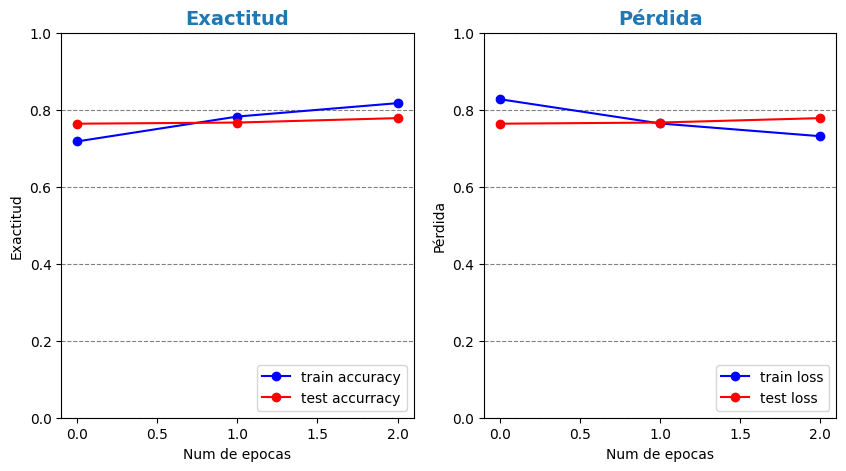

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (10, 5))
colors = ['b','r','g','y','cyan']


ax[0].plot(lst_train_acc, 'b',label='train accuracy', marker = 'o')
ax[0].plot(lst_test_acc,'r',label = 'test accurracy', marker = 'o')

ax[0].set_xlabel("Num de epocas")
ax[0].set_ylabel("Exactitud")
ax[0].set_ylim([0, 1])
ax[0].set_title("Exactitud", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax[0].legend(loc = 'lower right')
ax[0].grid(axis = 'y', color = 'gray', linestyle = 'dashed')

ax[1].plot(lst_train_loss,'b',label = 'train loss', marker = 'o')
ax[1].plot(lst_test_loss,'r',label = 'test loss', marker = 'o')

ax[1].set_xlabel("Num de epocas")
ax[1].set_ylabel("Pérdida")
ax[1].set_ylim([0, 1])
ax[1].set_title("Pérdida", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax[1].legend(loc = 'lower right')
ax[1].grid(axis = 'y', color = 'gray', linestyle = 'dashed')

plt.show()

### Predicciónes del modelo

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = [] #texto sin procesar solo para mostrar la relación
    predictions = [] #predicciones
    prediction_probs = [] # probabilidades de predicción
    real_values = [] #valores reales o el sentimiento que corresponde

    with torch.no_grad():
        for d in data_loader:
            text = d['full_text']
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            #probs = F.softmax(outputs, dim=1)

            texts.extend(text)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(labels)
    #Crear un DataFrame para revisar los resultados de las listas
    df_prediction = pd.DataFrame(list(zip(texts,predictions,prediction_probs,real_values)),
                                 columns = ['texts','predictions','prediction_probs','real_values'])

    #convertir las listas en tensores y retornar sus valores
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, prediction_probs, real_values, df_prediction

In [ ]:
y_texts, y_pred, y_pred_probs, y_test, df_prediction = get_predictions(
  model,test_data_loader2)

In [ ]:
df_prediction

In [ ]:
class_names = ['Negativo', 'Neutro', 'Positivo']

**Informe de Clasificación**

In [ ]:
#informe de clasificación
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negativo       0.75      0.75      0.75      1442
      Neutro       0.76      0.81      0.78      3567
    Positivo       0.78      0.70      0.74      2042

    accuracy                           0.76      7051
   macro avg       0.76      0.75      0.76      7051
weighted avg       0.76      0.76      0.76      7051



**Evaluación de los datos de prueba**

In [ ]:
test_acc2, test_loss2 = eval_model(
        model, test_data_loader2, loss_fn, device, n_examples=len(df_test2))
print('Prueba: Loss: {}, accuracy: {}'.format(test_loss2, test_acc2))

### Matriz de Confusión

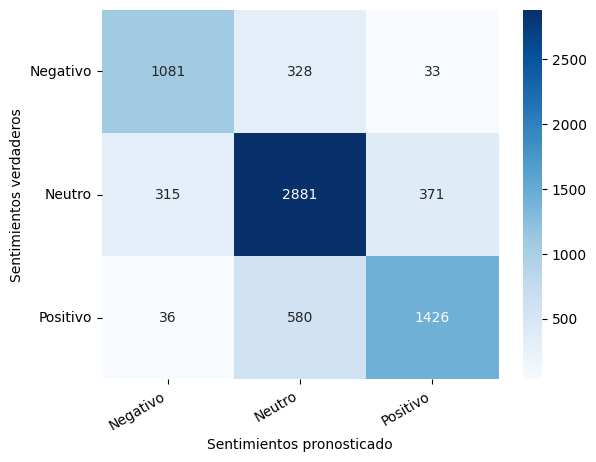

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Sentimientos verdaderos')
  plt.xlabel('Sentimientos pronosticado');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)